### Occlusion
- 두 이미지에서 동일한 object에 대해 매칭점을 찾을려고 하는데, 한 쪽 이미지에서 해당 이미지가 부분적으로 occlusion 돼 있는 경우

In [1]:
import numpy as np
import cv2
#Import necessary functions
from matplotlib import pyplot as plt
import skimage.io
import skimage.color
from planarH import computeH_ransac, computeH_ransac_adaptive, compositeH, computeH_norm, compositeH_panorama, compositeH_panorama_blend

In [2]:
img_dst = cv2.imread('../data/pano_left_hand.jpg')
img_src = cv2.imread('../data/pano_right_hand.jpg')
template_diagonal = int((img_src.shape[1]**2 + img_src.shape[0]**2)**(1/2))
img_dst_padded = cv2.copyMakeBorder(img_dst, top = template_diagonal, bottom= template_diagonal, left = template_diagonal, right = template_diagonal, borderType = 0)

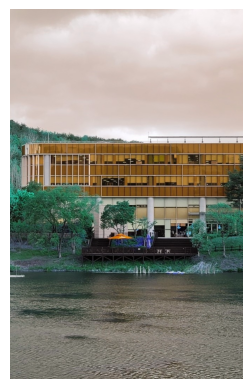

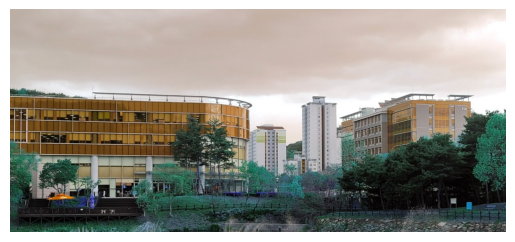

In [3]:
plt.imshow(img_dst)
plt.axis('off')
plt.show()
plt.imshow(img_src)
plt.axis('off')
plt.show()

In [4]:
# Load images
# Detect keypoints and extract descriptors
orb = cv2.ORB_create(nfeatures=40000,
                    scaleFactor=1.2,
                    nlevels=8,
                    edgeThreshold=31,
                    firstLevel=0,
                    WTA_K=2,
                    scoreType=cv2.ORB_HARRIS_SCORE,
                    patchSize=31,
                    fastThreshold=20)

kp1, des1 = orb.detectAndCompute(img_src, None)
kp2, des2 = orb.detectAndCompute(img_dst_padded, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches_cv = bf.match(des1, des2)

# Sort matches by distance
matches_cv = sorted(matches_cv, key=lambda x: x.distance)

# Select the top 10% accurate matches

num_matches = int(len(matches_cv) * 0.5)  # choose 10% of total matches
best_matches = matches_cv[:num_matches]


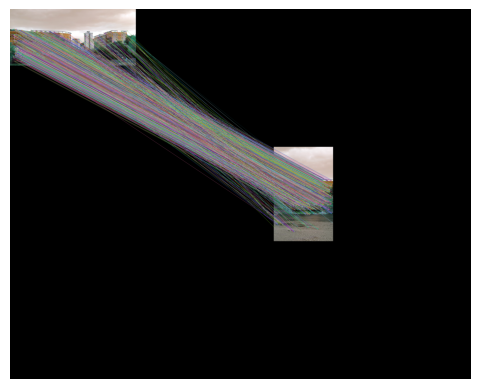

In [5]:
img_matches = cv2.drawMatches(img_src, kp1,img_dst_padded,  kp2, best_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


# Display the image with matches
plt.imshow(img_matches)
plt.axis('off')
plt.show()

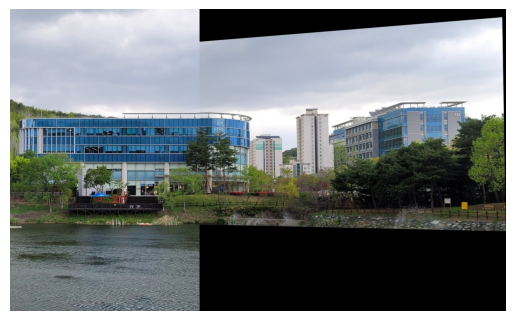

In [6]:
pts1_best = np.float32([kp1[m.queryIdx].pt for m in best_matches]).reshape(-1, 2)
pts2_best = np.float32([kp2[m.trainIdx].pt for m in best_matches]).reshape(-1, 2)

H2to1, inliers = computeH_ransac_adaptive(pts2_best, pts1_best, 300, 2)

H2to1 = computeH_norm(pts2_best[inliers], pts1_best[inliers])

panorama = compositeH_panorama(H2to1, img_dst, img_src)
result = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
plt.imshow(result)
plt.axis('off')
plt.show()

In [7]:
cv2.imwrite("../result/test.jpg", panorama)

True